In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import itertools
import torch.optim as optim
import numpy as np
import csv

In [2]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (ndarray): rotaion axis (normalized).
        theta (float): rotation angle in radian.

    Returns:
        - (ndarray) -- 3x3 rotation matrix.
    """
    K = np.array([[0.0, -n[2], n[1]], [n[2], 0.0, -n[0]], [-n[1], n[0], 0.0]])
    I = np.eye(3)
    R = I + np.sin(theta) * K + (1.0 - np.cos(theta)) * np.dot(K, K)
    return R


def create_shift_tensor(ks, Rs):
    """
    Create shift tensors for all sites.

    Args:
        ks (list): components of K, (Kxx, Kyy, Kzz, Kyz, Kzx, Kxy).
        Rs (list): symmetry operations for each site.

    Returns:
        - (list) -- shift tensors in each site.
    """
    k1, k2, k3, k4, k5, k6 = ks
    K = [[k1,k6,k5],[k6,k2,k4],[k5,k4,k3]]
    Ks = [R @ K @ R.T for R in Rs]
    return Ks


def nmr_shift(Ks, h):
    """
    Compute the NMR shift without the contributions from the quadrupolar interactions.

    Args:
        Ks (list): list of 3x3 shift tensors.
        h (ndarray): magnetic field.

    Returns:
        - (list) -- NMR shift for each K.
    """
    shift = [np.diag(h @ K @ h.T) for K in Ks]
    return shift


def compute_shift(n, s, ks, Rs):
    """
    Compute angle dependence of NMR shift.

    Args:
        n (list): rotation axis.
        s (list): starting vector.
        ks (list): components of K, (Kxx, Kyy, Kzz, Kyz, Kzx, Kxy).
        Rs (list): symmetry operations for each site.

    Returns:
        - (ndarray) -- angles.
        - (list) -- angle dependence of NMR shift around n axis.
        - (list) -- angle dependence of NMR shift around nxs axis.
    """
    theta = np.radians(range(91))

    n = np.array(n)
    n1 = n / np.linalg.norm(n)
    s = np.array(s)
    s = s / np.linalg.norm(s)
    n2 = np.cross(n1, s)
    h1 = np.array([rotation_matrix(n1, t) @ s for t in theta])
    h2 = np.array([rotation_matrix(n2, t) @ s for t in theta])

    Ks = create_shift_tensor(ks, Rs)

    shift1 = nmr_shift(Ks, h1)
    shift2 = nmr_shift(Ks, h2)

    return theta, shift1, shift2


def plot_data(theta, shift1, shift2):
    """
    Plot angle dependences.

    Args:
        theta (ndarray): angles.
        shift1 (list): angle dependence of NMR shift around n axis.
        shift2 (list): angle dependence of NMR shift around nxs axis.
    """
    fig, axes = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
    axes.set_title("Knight shift of Te")
    axes.set_xlabel("Rotation angle [deg.]", fontsize=15)
    axes.set_ylabel(r"Knight shift [$\times {10}^4$]", fontsize=15)

    axes.set_xlim([0, 90])
    axes.grid()

    n_site = len(shift1)
    colors = ["blue", "green", "red"]
    theta = theta * 180/np.pi
    for site in range(n_site):
        axes.plot(theta, shift1[site]*10000, "-", color=colors[site], label=f'$K_{site+1}$')
    for site in range(n_site):
        axes.plot(theta, shift2[site]*10000, "--", color=colors[site], label=f'$K_{site+1}$')
    axes.legend()

    plt.autoscale(enable=True, axis='y')
    plt.show()

def output_shift_values(theta, shift1, shift2):
    """
    Output angle and shift values in the specified format.
    """
    for j in range(3):
        print(f"Angle,Shift1[{j+1}] value")  # jの値を表示する
        for i in range(0, 91):
            print(f"{i},{shift1[j][i]*10000}")
    for j in range(3):
        print(f"Angle,Shift2[{j+1}] value")  # jの値を表示する
        for i in range(0, 91):
            print(f"{i},{shift2[j][i]*10000}")

In [3]:
def generate_vectors():
    # t1, p1 をランダム生成
    t1 = np.random.uniform(0, 180)  # 0° <= t1 <= 180°
    p1 = np.random.uniform(-180, 180)  # -180° <= p1 <= 180°

    # ベクトル n を計算
    nx = np.cos(np.radians(p1)) * np.sin(np.radians(t1))
    ny = np.sin(np.radians(p1)) * np.sin(np.radians(t1))
    nz = np.cos(np.radians(t1))
    n = np.array([nx, ny, nz])

    while True:
        # ランダムなベクトルを生成
        random_vec = np.random.randn(3)
        # 直交条件を満たすように調整
        s = random_vec - np.dot(random_vec, n) * n
        if np.linalg.norm(s) > 1e-6:  # 0ベクトルでない場合にのみ採用
            s = s / np.linalg.norm(s)  # s を正規化
            # t2, p2 を逆算
            t2 = np.degrees(np.arccos(s[2]))
            p2 = np.degrees(np.arctan2(s[1], s[0]))
            if p2 < 0:
                p2 += 360  # p2 を 0°〜360° に変換

            # p2 が 120° 以下であれば終了
            if p2 <= 120:
                break

    return t1, p1, t2, p2, n, s

# ランダム生成と内積の確認
t1, p1, t2, p2, n, s = generate_vectors()
dot_product = np.dot(n, s)

print(f"t1: {t1}, p1: {p1}")
print(f"t2: {t2}, p2: {p2}")
print(f"n: {n}")
print(f"s: {s}")
print(f"内積 (n・s): {dot_product}")

t1: 144.3555923526658, p1: 38.82429802610355
t2: 57.53366220942632, p2: 11.353171162985147
n: [ 0.45400664  0.36534782 -0.81264934]
s: [0.82719765 0.16608885 0.53680401]
内積 (n・s): 3.2906616136947406e-16


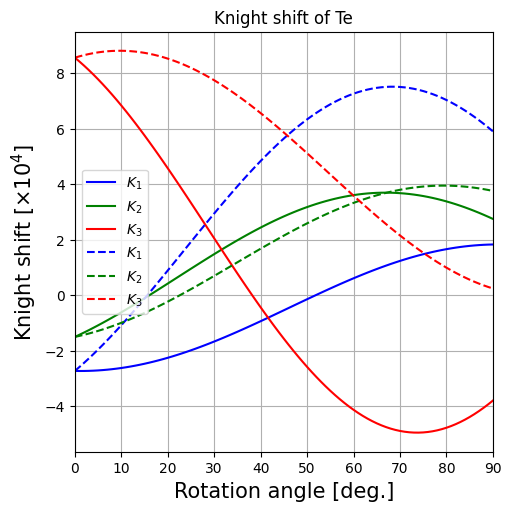

Angle,Shift1[1] value
0,-2.7341310979215394
1,-2.7359544738757724
2,-2.7349975035609
3,-2.7312613528978433
4,-2.724750573810673
5,-2.7154730986808033
6,-2.703440230682589
7,-2.6886666300121673
8,-2.6711702960262556
9,-2.650972545312712
10,-2.628097985719557
11,-2.6025744863740985
12,-2.574433143728694
13,-2.543708243674519
14,-2.5104372197694773
15,-2.4746606076311903
16,-2.436421995550583
17,-2.395767971386273
18,-2.3527480658044277
19,-2.307414691933291
20,-2.2598230815058553
21,-2.210031217568501
22,-2.158099763837586
23,-2.1040919907900544
24,-2.0480736985781043
25,-1.990113136861841
26,-1.9302809216575751
27,-1.8686499493030868
28,-1.805295307644665
29,-1.7402941845541375
30,-1.673725773887336
31,-1.6056711789985787
32,-1.53621331392873
33,-1.4654368023872162
34,-1.3934278746510609
35,-1.3202742625065902
36,-1.2460650923617465
37,-1.1708907766593128
38,-1.0948429037232486
39,-1.018014126172456
40,-0.9404980480378121
41,-0.8623891107200861
42,-0.7837824779276432
43,-0.7047739197341

In [4]:
# In the case of Te. (Te1 is on y-bond).
# ks = [-8.572e-4, 1.146e-4, 0.0, 8.830e-4, 0.0, 0.0]

ks = [-5e-4, 5e-4, 5e-4, -5e-4, 0.0, 0.0]

E = np.eye(3)
C3 = rotation_matrix([0,0,1], 2.0*np.pi/3.0) # for Te2.
C3i = C3.T # for Te3.

Rs = [E, C3i, C3]

theta, shift1, shift2 = compute_shift(n, s, ks, Rs)
plot_data(theta, shift1, shift2)

# 指定フォーマットで出力
output_shift_values(theta, shift1, shift2)

In [5]:

def save_to_csv(filename, angles, shifts, index):
    """
    Save the angles and shifts to a CSV file.

    Args:
        filename (str): Output CSV file name.
        angles (ndarray): Array of angles.
        shifts (list): Shift values for one site.
        index (int): Site index (1-based).
    """
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Header
        writer.writerow(["x", "y"])
        # Data
        for angle, shift in zip(angles, shifts):
            writer.writerow([angle, shift])

def output_shift_to_csv(theta, shift1, shift2):
    """
    Output angle and shift values to CSV files.

    Args:
        theta (ndarray): Array of angles.
        shift1 (list): Shift values for each site around n axis.
        shift2 (list): Shift values for each site around nxs axis.
    """
    # Convert angles to degrees
    angles = np.round(theta * 180 / np.pi).astype(int)  # 四捨五入で整数化
    
    # Save Shift1 data
    for i, shifts in enumerate(shift1, start=1):
        filename = f"sample({i}).csv"
        save_to_csv(filename, angles, shifts * 10000, i)
    
    # Save Shift2 data
    for i, shifts in enumerate(shift2, start=1):
        filename = f"sample{i}.csv"
        save_to_csv(filename, angles, shifts * 10000, i)

# 実行例
output_shift_to_csv(theta, shift1, shift2)

In [6]:
# 回転行列(PyTorch版)
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (torch.Tensor): Rotation axis (normalized).
        theta (float): Rotation angle in radian.

    Returns:
        - (torch.Tensor) -- 3x3 rotation matrix.
    """
    K = torch.tensor([[0.0, -n[2], n[1]], 
                      [n[2], 0.0, -n[0]], 
                      [-n[1], n[0], 0.0]])
    I = torch.eye(3)
    R = I + torch.sin(theta) * K + (1.0 - torch.cos(theta)) * torch.mm(K, K)
    return R

# 外積(PyTorch版)
def cross_product(v1, v2):
    return torch.cross(v1, v2, dim=0)

# 磁場ベクトル(PyTorch版)
def magnetic(axis, vec, theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    axis = axis.unsqueeze(0)  # (1, 3)
    vec = vec.unsqueeze(0)    # (1, 3)
    
    rotated_vecs = []
    for i in range(theta.size(0)):
        theta_i = theta[i]
        cos_theta_i = cos_theta[i]
        sin_theta_i = sin_theta[i]
        
        axis_i = axis[0]
        vec_i = vec[0]
        
        rotated_vec = vec_i * cos_theta_i + cross_product(axis_i, vec_i) * sin_theta_i + axis_i * (torch.matmul(axis_i.unsqueeze(1).T, vec_i.unsqueeze(1)).squeeze() * (1 - cos_theta_i))
        rotated_vecs.append(rotated_vec)
    
    return torch.stack(rotated_vecs)

# モデル関数(PyTorch版)
def model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    rad = torch.pi / 180.0  # Conversion factor from degrees to radians
    nx = torch.cos(p1 * rad) * torch.sin(t1 * rad)
    ny = torch.sin(p1 * rad) * torch.sin(t1 * rad)
    nz = torch.cos(t1 * rad)
    sx = torch.cos(p2 * rad) * torch.sin(t2 * rad)
    sy = torch.sin(p2 * rad) * torch.sin(t2 * rad)
    sz = torch.cos(t2 * rad)
    theta = x * rad

    # Define matrices
    E = torch.eye(3)
    C3 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor([2.0 * torch.pi / 3.0])) # for Te2.
    C3i = C3.T # for Te3.
    Rs = [E, C3i, C3]
    
    h = magnetic(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]), theta)
    ht = magnetic((cross_product(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]))), torch.stack([sx, sy, sz]), theta)
    k = torch.stack([
    torch.stack([k1, k6, k5]),
    torch.stack([k6, k2, k4]),
    torch.stack([k5, k4, k3])
    ])
    Ks = [torch.einsum('ik,kl,jl->ij', R, k, R) for R in Rs]
    shift1 = [torch.einsum('ij,jk,ik->i', h, K, h) for K in Ks]
    shift2 = [torch.einsum('ij,jk,ik->i', ht, K, ht) for K in Ks]
    return {'shift1': torch.stack(shift1), 'shift2': torch.stack(shift2)}

In [7]:
# 各CSVファイルの読み込み
csv_files1 = ['sample(1).csv', 'sample(2).csv', 'sample(3).csv']
df1 = [pd.read_csv(f) for f in csv_files1]

csv_files2 = ['sample1.csv', 'sample2.csv', 'sample3.csv']
df2 = [pd.read_csv(f) for f in csv_files2]

dfs = [df1, df2]

# データの抽出
x_values = []
y_values = []

for df_group in dfs:
    for i in range(len(df_group)):
        x_values.append(df_group[i]['x'].values)
        y_values.append(df_group[i]['y'].values)

# リストの全てのデータをtorch.tensorに変換
x_tensors = []
y_tensors = []

for x, y in zip(x_values, y_values):
    x_tensors.append(torch.tensor(x, dtype=torch.float32, requires_grad=True))
    y_tensors.append(torch.tensor(y, dtype=torch.float32))

# 結果を個別に代入（必要なら）
x1, x2, x3, x4, x5, x6 = x_tensors
y1, y2, y3, y4, y5, y6 = y_tensors

In [8]:
# 損失関数の定義
def loss_fn(y_p, y):
    squared_diffs = (y_p - y)**2
    return squared_diffs.mean()

In [9]:
# 損失関数の和
def combined_loss_fn(*args):
    total_loss = 0
    # y_predとy_actualをペアでループしながらlossを計算
    for y_pred, y_actual in zip(args[::2], args[1::2]):
        total_loss += loss_fn(y_pred, y_actual)
    
    return total_loss

In [10]:
# 全ての順列を生成
permutations = list(itertools.permutations([0, 1, 2]))

# 最適化のためのobjective関数
def objective(trial, perm):
    k1 = torch.tensor(trial.suggest_float('k1', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k2 = torch.tensor(trial.suggest_float('k2', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k3 = torch.tensor(trial.suggest_float('k3', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k4 = torch.tensor(trial.suggest_float('k4', 0.0, 10.0), dtype=torch.float32, requires_grad=True)
    k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
    k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
    t1 = torch.tensor(trial.suggest_float('t1', 0.0, 180.0), dtype=torch.float32, requires_grad=True)
    p1 = torch.tensor(trial.suggest_float('p1', -180.0, 180.0), dtype=torch.float32, requires_grad=True)
    t2 = torch.tensor(trial.suggest_float('t2', 0.0, 180.0), dtype=torch.float32, requires_grad=True)
    p2 = torch.tensor(trial.suggest_float('p2', 0.0, 120.0), dtype=torch.float32, requires_grad=True)

    # モデルにこれらのパラメータを使用
    outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]
    
    y_p1, y_p2, y_p3 = [outputs[i]['shift1'][perm[i]] for i in range(3)]
    y_p4, y_p5, y_p6 = [outputs[i+3]['shift2'][perm[i]] for i in range(3)]

    loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

    return loss.item()

# 最適化ループ
max_global_iterations = 5  # グローバルな最大繰り返し回数
global_iteration = 0

global_best_loss = float('inf')
global_best_params = None
global_best_combination = None

# 損失関数が0.01以下になるまで以下の計算を繰り返す
while global_best_loss > 1e-2 and global_iteration < max_global_iterations:
    print(f"\nGlobal iteration {global_iteration + 1}")
    # 36通りの組み合わせごとにエポック計算を行うためのループ
    for perm in permutations:
        print(f"Evaluating combination: perm1={perm}, perm2={perm}")

        # 最適化のための変数初期化
        best_epoch0_loss = float('inf')
        best_params = None

        for _ in range(5):
            # Optunaで最適化
            study = optuna.create_study(direction='minimize')
            study.optimize(lambda trial: objective(trial, perm), n_trials=100)

            # epoch0のLossが最小のパラメータを保持
            if study.best_value < best_epoch0_loss:
                best_epoch0_loss = study.best_value
                best_params = study.best_params

        # エポック計算 (各組み合わせごとに計算)
        if best_params is not None:
            print(f"Starting training for combination: perm1={perm}, perm2={perm}")
            
            k1 = torch.nn.Parameter(torch.tensor(best_params['k1']))
            k2 = torch.nn.Parameter(torch.tensor(best_params['k2']))
            k3 = torch.nn.Parameter(torch.tensor(best_params['k3']))
            k4 = torch.nn.Parameter(torch.tensor(best_params['k4']))
            k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
            k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
            t1 = torch.nn.Parameter(torch.tensor(best_params['t1']))
            p1 = torch.nn.Parameter(torch.tensor(best_params['p1']))
            t2 = torch.nn.Parameter(torch.tensor(best_params['t2']))
            p2 = torch.nn.Parameter(torch.tensor(best_params['p2']))

            optimizer = optim.Adam([k1, k2, k3, k4, t1, p1, t2, p2], lr=1e-1)
            prev_loss = float('inf')

            # エポックごとのトレーニング
            best_params_during_epoch = None  # エポックごとの最良パラメータ
            best_epoch_loss = float('inf')  # 最良のロスを記録

            # エポックごとのトレーニング
            for epoch in range(300000):
                optimizer.zero_grad()

                outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

                y_p1, y_p2, y_p3 = [outputs[i]['shift1'][perm[i]] for i in range(3)]
                y_p4, y_p5, y_p6 = [outputs[i+3]['shift2'][perm[i]] for i in range(3)]

                loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

                if epoch == 0:
                    epoch0_loss = loss.item()
                    if epoch0_loss >= 35:
                        print(f"Epoch 0 Loss is {epoch0_loss}, which is >= 35. Stopping training.")
                        break
                
                # 最良のロスを持つ場合はパラメータを保存
                if loss.item() < best_epoch_loss:
                    best_epoch_loss = loss.item()
                    best_params_during_epoch = {
                        'k1': k1.item(),
                        'k2': k2.item(),
                        'k3': k3.item(),
                        'k4': k4.item(),
                        'k5': k5.item(),
                        'k6': k6.item(),
                        't1': t1.item(),
                        'p1': p1.item(),
                        't2': t2.item(),
                        'p2': p2.item()
                    }

                if loss.item() > prev_loss:
                    print(f"Loss increased at epoch {epoch}. Stopping training.")
                    break

                prev_loss = loss.item()
                loss.backward()

                # 勾配を確認
                for name, param in zip(['k1', 'k2', 'k3', 'k4', 't1', 'p1', 't2', 'p2'], [k1, k2, k3, k4, t1, p1, t2, p2]):
                    print(f"{name} grad: {param.grad}")

                optimizer.step()

                with torch.no_grad():
                    for param in [k1, k2, k3, k4]:
                        param.data = torch.clamp(param.data, -10.0, 10.0)
                    for param in [k4]:
                        param.data = torch.clamp(param.data, 0.0, 10.0)
                    for param in [t1, t2]:
                        param.data = torch.clamp(param.data, 0.0, 180.0)
                    for param in [p1]:
                        param.data = torch.clamp(param.data, -180.0, 180.0)
                    for param in [p2]:
                        param.data = torch.clamp(param.data, 0.0, 120.0)

                if epoch % 100 == 0:
                    print(f'Epoch {epoch}, Loss: {loss.item()}')
                    # パラメータを表示する
                    print(f'Parameters: k1={k1.item()}, k2={k2.item()}, k3={k3.item()}, k4={k4.item()}, k5={k5.item()}, k6={k6.item()}, t1={t1.item()}, p1={p1.item()}, t2={t2.item()}, p2={p2.item()}')

            # 最良のパラメータを表示
            if best_params_during_epoch is not None:
                print(f"Best params during epoch training: {best_params_during_epoch}")
                # 最良のパラメータをTensorに変換して使用
                k1, k2, k3, k4, k5, k6, t1, p1, t2, p2 = [torch.tensor(best_params_during_epoch[param], dtype=torch.float32) for param in ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 't1', 'p1', 't2', 'p2']]
            else:
                print("No improvement in loss during epoch training.")

            # 現在の組み合わせの最小Lossをグローバルな最小Lossと比較
            if prev_loss < global_best_loss:
                global_best_loss = prev_loss
                global_best_params = best_params_during_epoch
                global_best_combination = (perm, perm)

            print(f"Finished training for combination: perm1={perm}, perm2={perm}")


    print(f"Global best Loss after iteration {global_iteration + 1}: {global_best_loss}")
    global_iteration += 1

print(f"\nOptimization completed.")
print(f"Global best Loss: {global_best_loss}")
print(f"Global best params: {global_best_params}")
print(f"Global best combination: {global_best_combination}")

[I 2024-11-27 10:53:37,116] A new study created in memory with name: no-name-03cd5ed0-589b-4231-94fc-1aa2ef66e265
[I 2024-11-27 10:53:37,257] Trial 0 finished with value: 423.55987548828125 and parameters: {'k1': 3.5865976715918624, 'k2': 1.8657171981079994, 'k3': -9.12476428016128, 'k4': 9.961709335963963, 't1': 23.344234973693837, 'p1': 169.30890270346435, 't2': 40.25538812133386, 'p2': 86.32989839111376}. Best is trial 0 with value: 423.55987548828125.



Global iteration 1
Evaluating combination: perm1=(0, 1, 2), perm2=(0, 1, 2)


[I 2024-11-27 10:53:37,304] Trial 1 finished with value: 195.1726837158203 and parameters: {'k1': 7.126946922983155, 'k2': -3.9714280714530688, 'k3': 5.69329823792706, 'k4': 5.074179397529088, 't1': 70.92752494383886, 'p1': -153.60249992961906, 't2': 171.41251193212943, 'p2': 61.10188015122737}. Best is trial 1 with value: 195.1726837158203.
[I 2024-11-27 10:53:37,350] Trial 2 finished with value: 259.437255859375 and parameters: {'k1': -4.586751061082522, 'k2': 5.291291915480949, 'k3': 9.785967341077054, 'k4': 2.493481645268113, 't1': 178.63896234124314, 'p1': 157.15815074285126, 't2': 27.35792806546812, 'p2': 35.826597059784426}. Best is trial 1 with value: 195.1726837158203.
[I 2024-11-27 10:53:37,395] Trial 3 finished with value: 266.1689147949219 and parameters: {'k1': -5.717719846946398, 'k2': 6.0856011054579895, 'k3': 1.5683115202382787, 'k4': 7.926638545236273, 't1': 65.6108743877172, 'p1': -32.74219781802776, 't2': 162.86252378070128, 'p2': 21.450474585784214}. Best is trial 1

Starting training for combination: perm1=(0, 1, 2), perm2=(0, 1, 2)
k1 grad: 1.9061604738235474
k2 grad: -0.8560798168182373
k3 grad: 0.47634172439575195
k4 grad: -0.647601306438446
t1 grad: 0.18437695503234863
p1 grad: 0.11463399976491928
t2 grad: -0.463896244764328
p2 grad: -0.2748275399208069
Epoch 0, Loss: 16.364906311035156
Parameters: k1=5.162204742431641, k2=5.9165425300598145, k3=-0.42593783140182495, k4=5.199209213256836, k5=0.0, k6=0.0, t1=111.46998596191406, p1=110.19273376464844, t2=135.7632598876953, p2=31.24154281616211
k1 grad: 1.7342320680618286
k2 grad: -0.8901411294937134
k3 grad: -0.02754431962966919
k4 grad: -0.357389360666275
t1 grad: 0.1913473904132843
p1 grad: 0.09741365909576416
t2 grad: -0.44470342993736267
p2 grad: -0.24421826004981995
k1 grad: 1.5917054414749146
k2 grad: -0.8969734311103821
k3 grad: -0.35204827785491943
k4 grad: -0.08112069964408875
t1 grad: 0.19747264683246613
p1 grad: 0.08090895414352417
t2 grad: -0.432016521692276
p2 grad: -0.2141919285058

[I 2024-11-27 10:55:05,809] A new study created in memory with name: no-name-5f690f6f-3a1d-42d2-bfa7-52b21da176b7


k1 grad: -3.3676624298095703e-06
k2 grad: -3.2491981983184814e-05
k3 grad: -3.2782554626464844e-06
k4 grad: 7.146969437599182e-06
t1 grad: 0.0010913165751844645
p1 grad: -4.3451786041259766e-05
t2 grad: 0.00010973401367664337
p2 grad: -8.766353130340576e-05
k1 grad: -2.473592758178711e-06
k2 grad: -2.997368574142456e-05
k3 grad: -1.6689300537109375e-06
k4 grad: 5.966052412986755e-06
t1 grad: 0.0010770037770271301
p1 grad: -4.111975431442261e-05
t2 grad: 0.00010765530169010162
p2 grad: -8.741207420825958e-05
Loss increased at epoch 647. Stopping training.
Best params during epoch training: {'k1': 1.5788294076919556, 'k2': 8.326416969299316, 'k3': -0.14427615702152252, 'k4': 5.478374481201172, 'k5': 0.0, 'k6': 0.0, 't1': 86.61813354492188, 'p1': 116.88013458251953, 't2': 137.4011688232422, 'p2': 32.62715148925781}
Finished training for combination: perm1=(0, 1, 2), perm2=(0, 1, 2)
Evaluating combination: perm1=(0, 2, 1), perm2=(0, 2, 1)


[I 2024-11-27 10:55:05,921] Trial 0 finished with value: 623.2492065429688 and parameters: {'k1': -9.549094241649343, 'k2': -9.379124149450869, 'k3': -9.855130337191023, 'k4': 6.5504279174459175, 't1': 96.81012567966232, 'p1': 34.431466345152074, 't2': 80.73014462043804, 'p2': 10.772910124805692}. Best is trial 0 with value: 623.2492065429688.
[I 2024-11-27 10:55:05,970] Trial 1 finished with value: 476.73529052734375 and parameters: {'k1': -7.389624630896703, 'k2': 8.19976668175443, 'k3': -7.963909798716258, 'k4': 5.449663470877812, 't1': 123.85787888368448, 'p1': 115.81896362969599, 't2': 132.14002009089927, 'p2': 54.4829480043334}. Best is trial 1 with value: 476.73529052734375.
[I 2024-11-27 10:55:06,017] Trial 2 finished with value: 259.8420715332031 and parameters: {'k1': 4.360650374620356, 'k2': -3.772406795783983, 'k3': -7.020017197609246, 'k4': 6.9330135361821394, 't1': 107.49011162727008, 'p1': -118.9319799588073, 't2': 87.80323605532263, 'p2': 24.76573279666645}. Best is tri

Starting training for combination: perm1=(0, 2, 1), perm2=(0, 2, 1)
k1 grad: 1.4800529479980469
k2 grad: -3.9894704818725586
k3 grad: -1.22660231590271
k4 grad: 6.216054916381836
t1 grad: -0.2843506932258606
p1 grad: -0.21368858218193054
t2 grad: -0.7106021046638489
p2 grad: 0.06645309925079346
Epoch 0, Loss: 28.890451431274414
Parameters: k1=6.898000240325928, k2=-7.282370567321777, k3=5.006912708282471, k4=1.1683728694915771, k5=0.0, k6=0.0, t1=20.282562255859375, p1=99.25698852539062, t2=108.34850311279297, p2=60.735321044921875
k1 grad: 1.4089624881744385
k2 grad: -3.707289934158325
k3 grad: -0.9055564999580383
k4 grad: 5.91445255279541
t1 grad: -0.27742674946784973
p1 grad: -0.20570231974124908
t2 grad: -0.6660299301147461
p2 grad: 0.03951370716094971
k1 grad: 1.339371919631958
k2 grad: -3.428072214126587
k3 grad: -0.5899658799171448
k4 grad: 5.611033916473389
t1 grad: -0.27051016688346863
p1 grad: -0.19783321022987366
t2 grad: -0.6206942796707153
p2 grad: 0.014342427253723145
k1 

[I 2024-11-27 10:55:40,899] A new study created in memory with name: no-name-62d5916a-f495-4fec-a08e-1deff5fae15b
[I 2024-11-27 10:55:40,995] Trial 0 finished with value: 72.64775848388672 and parameters: {'k1': -4.204900585755138, 'k2': 0.35261813603110603, 'k3': 8.121182708528213, 'k4': 5.082311469756254, 't1': 65.42144507389627, 'p1': 24.504844101210296, 't2': 110.44357487557471, 'p2': 11.907672593289863}. Best is trial 0 with value: 72.64775848388672.
[I 2024-11-27 10:55:41,043] Trial 1 finished with value: 283.12725830078125 and parameters: {'k1': -1.3432153514765037, 'k2': 1.6287666316408576, 'k3': -9.966863104474541, 'k4': 1.9735434621345693, 't1': 143.88990658099743, 'p1': 158.5809154239538, 't2': 55.1893305385439, 'p2': 51.42044213584616}. Best is trial 0 with value: 72.64775848388672.


k1 grad: -0.16954706609249115
k2 grad: 0.2972090244293213
k3 grad: 0.07995283603668213
k4 grad: 2.1281931400299072
t1 grad: -0.12986306846141815
p1 grad: -0.0474882647395134
t2 grad: 0.09541178494691849
p2 grad: 0.0020124688744544983
Loss increased at epoch 27. Stopping training.
Best params during epoch training: {'k1': 5.375184059143066, 'k2': -5.352970123291016, 'k3': 5.186428546905518, 'k4': 0.0, 'k5': 0.0, 'k6': 0.0, 't1': 22.558151245117188, 'p1': 101.43623352050781, 't2': 110.2099380493164, 'p2': 61.927879333496094}
Finished training for combination: perm1=(0, 2, 1), perm2=(0, 2, 1)
Evaluating combination: perm1=(1, 0, 2), perm2=(1, 0, 2)


[I 2024-11-27 10:55:41,092] Trial 2 finished with value: 250.3892364501953 and parameters: {'k1': -3.386399630313937, 'k2': 2.0896944313159516, 'k3': 1.358589860254174, 'k4': 7.390391623030253, 't1': 26.656592859767766, 'p1': 24.06237755821425, 't2': 76.74453276998315, 'p2': 114.41907913838256}. Best is trial 0 with value: 72.64775848388672.
[I 2024-11-27 10:55:41,140] Trial 3 finished with value: 348.0715637207031 and parameters: {'k1': -0.730043909778912, 'k2': -4.04509793107785, 'k3': -7.985905076969624, 'k4': 4.298596305056166, 't1': 28.840571386460333, 'p1': -0.9877931787902696, 't2': 54.98139811927525, 'p2': 68.88896139501792}. Best is trial 0 with value: 72.64775848388672.
[I 2024-11-27 10:55:41,247] Trial 4 finished with value: 353.3316955566406 and parameters: {'k1': 5.871220181702599, 'k2': 4.741761924506074, 'k3': -8.9654888633867, 'k4': 1.2802252420462557, 't1': 147.93041291572752, 'p1': -91.0511391701317, 't2': 33.12768928306488, 'p2': 57.535503934504334}. Best is trial 0 

Starting training for combination: perm1=(1, 0, 2), perm2=(1, 0, 2)
k1 grad: -4.267764568328857
k2 grad: 0.7620948553085327
k3 grad: 0.5037925839424133
k4 grad: -2.6343517303466797
t1 grad: 1.7077991962432861
p1 grad: 0.016575530171394348
t2 grad: -0.19504734873771667
p2 grad: -0.8782739639282227
Epoch 0, Loss: 30.243520736694336
Parameters: k1=-0.8037977814674377, k2=5.303823947906494, k3=-0.6714057326316833, k4=5.970376968383789, k5=0.0, k6=0.0, t1=102.28638458251953, p1=-35.58820724487305, t2=116.94745635986328, p2=42.61540985107422
k1 grad: -4.0412821769714355
k2 grad: 0.4099052846431732
k3 grad: 0.4414539933204651
k4 grad: -2.3369929790496826
t1 grad: 1.6527310609817505
p1 grad: 0.019919052720069885
t2 grad: -0.1753871738910675
p2 grad: -0.8560610413551331
k1 grad: -3.808948516845703
k2 grad: 0.07623392343521118
k3 grad: 0.3819221258163452
k4 grad: -2.0393576622009277
t1 grad: 1.597870945930481
p1 grad: 0.02342917025089264
t2 grad: -0.15454286336898804
p2 grad: -0.8336561918258667

[I 2024-11-27 10:56:57,107] A new study created in memory with name: no-name-572d2cf2-002e-476c-b000-549ddcc165b2


k1 grad: 5.030632019042969e-05
k2 grad: -3.1888484954833984e-06
k3 grad: -3.4183263778686523e-05
k4 grad: 9.566545486450195e-05
t1 grad: 0.002817531581968069
p1 grad: 8.395686745643616e-05
t2 grad: 7.361918687820435e-05
p2 grad: 0.0013899058103561401
k1 grad: 4.76837158203125e-05
k2 grad: -6.9141387939453125e-06
k3 grad: -3.4242868423461914e-05
k4 grad: 9.25213098526001e-05
t1 grad: 0.0027701847720891237
p1 grad: 8.278712630271912e-05
t2 grad: 7.177144289016724e-05
p2 grad: 0.0013664960861206055
Loss increased at epoch 500. Stopping training.
Best params during epoch training: {'k1': -0.0031301509588956833, 'k2': 5.830418586730957, 'k3': -1.5890274047851562, 'k4': 6.866615295410156, 'k5': 0.0, 'k6': 0.0, 't1': 89.42904663085938, 'p1': -44.358726501464844, 't2': 112.9313735961914, 'p2': 40.86343002319336}
Finished training for combination: perm1=(1, 0, 2), perm2=(1, 0, 2)
Evaluating combination: perm1=(1, 2, 0), perm2=(1, 2, 0)


[I 2024-11-27 10:56:57,157] Trial 0 finished with value: 414.0148620605469 and parameters: {'k1': 2.0083794752113686, 'k2': -5.727693201112897, 'k3': 4.836304199149598, 'k4': 9.867475537092192, 't1': 76.11696880422662, 'p1': -178.92227703021726, 't2': 154.930210050764, 'p2': 119.97810786987783}. Best is trial 0 with value: 414.0148620605469.
[I 2024-11-27 10:56:57,234] Trial 1 finished with value: 162.65802001953125 and parameters: {'k1': -1.0110583903107297, 'k2': 4.054319061150979, 'k3': -3.8467781911372834, 'k4': 5.46581342537353, 't1': 96.66831064511915, 'p1': -140.49619643699918, 't2': 124.16266234764274, 'p2': 24.45145042056481}. Best is trial 1 with value: 162.65802001953125.
[I 2024-11-27 10:56:57,278] Trial 2 finished with value: 238.05218505859375 and parameters: {'k1': 1.446092632905069, 'k2': -6.10487373964167, 'k3': 4.472221023773814, 'k4': 0.9311216929825561, 't1': 104.93624389534271, 'p1': 44.65423609451031, 't2': 88.08616127313802, 'p2': 75.24331138220998}. Best is tria

Starting training for combination: perm1=(1, 2, 0), perm2=(1, 2, 0)
k1 grad: 3.252836227416992
k2 grad: 1.1436562538146973
k3 grad: 1.108597755432129
k4 grad: -3.998732805252075
t1 grad: 0.10312237590551376
p1 grad: -0.029353948310017586
t2 grad: 0.7127141356468201
p2 grad: -0.18359039723873138
Epoch 0, Loss: 18.49700927734375
Parameters: k1=-2.031315803527832, k2=4.22313928604126, k3=7.320866107940674, k4=2.5037941932678223, k5=0.0, k6=0.0, t1=152.2026824951172, p1=-168.81900024414062, t2=77.04183197021484, p2=74.82437133789062
k1 grad: 2.820082187652588
k2 grad: 0.7231321930885315
k3 grad: 0.8319586515426636
k4 grad: -3.8062124252319336
t1 grad: 0.06994272768497467
p1 grad: -0.019390784204006195
t2 grad: 0.7290232181549072
p2 grad: -0.1691659837961197
k1 grad: 2.393235683441162
k2 grad: 0.31539857387542725
k3 grad: 0.5617104768753052
k4 grad: -3.6129937171936035
t1 grad: 0.03713249787688255
p1 grad: -0.010076254606246948
t2 grad: 0.7454943060874939
p2 grad: -0.15424039959907532
k1 gr

[I 2024-11-27 10:57:58,310] A new study created in memory with name: no-name-972c0393-ffa3-4951-bb1f-c57731ac6504
[I 2024-11-27 10:57:58,411] Trial 0 finished with value: 504.7926025390625 and parameters: {'k1': -8.63209506386356, 'k2': 9.896674870737815, 'k3': -9.184379878594466, 'k4': 6.61367027299658, 't1': 136.58014295284357, 'p1': 25.468974339837104, 't2': 131.13695823450936, 'p2': 48.54394534127975}. Best is trial 0 with value: 504.7926025390625.
[I 2024-11-27 10:57:58,455] Trial 1 finished with value: 350.7161560058594 and parameters: {'k1': -6.840449853466715, 'k2': -2.171422021664416, 'k3': 6.07819089892881, 'k4': 8.77444823548316, 't1': 163.516803694431, 'p1': -2.992083746040919, 't2': 118.24330389647804, 'p2': 35.15248963576029}. Best is trial 1 with value: 350.7161560058594.


k1 grad: 0.00014024972915649414
k2 grad: -2.1263957023620605e-05
k3 grad: -2.3871660232543945e-05
k4 grad: 5.1721930503845215e-05
t1 grad: 1.959502696990967e-06
p1 grad: 0.04601871967315674
t2 grad: 0.0009860290447250009
p2 grad: 1.2182630598545074e-05
Loss increased at epoch 346. Stopping training.
Best params during epoch training: {'k1': -4.645062446594238, 'k2': 4.640811920166016, 'k3': 7.690930366516113, 'k4': 4.994707107543945, 'k5': 0.0, 'k6': 0.0, 't1': 152.6070098876953, 'p1': -180.0, 't2': 63.50971603393555, 'p2': 68.9594497680664}
Finished training for combination: perm1=(1, 2, 0), perm2=(1, 2, 0)
Evaluating combination: perm1=(2, 0, 1), perm2=(2, 0, 1)


[I 2024-11-27 10:57:58,500] Trial 2 finished with value: 204.16395568847656 and parameters: {'k1': 6.24646739363833, 'k2': -2.716364338007164, 'k3': 9.248733513568215, 'k4': 4.195719105633317, 't1': 70.46161113895583, 'p1': 81.07610156572059, 't2': 115.92840089987405, 'p2': 35.90698458479584}. Best is trial 2 with value: 204.16395568847656.
[I 2024-11-27 10:57:58,546] Trial 3 finished with value: 106.76950073242188 and parameters: {'k1': 3.3071063989304683, 'k2': 0.3976909252413172, 'k3': -3.1060577016858186, 'k4': 4.359776630242078, 't1': 151.30852280219506, 'p1': -75.17748185627505, 't2': 113.75210564048693, 'p2': 65.40540496580448}. Best is trial 3 with value: 106.76950073242188.
[I 2024-11-27 10:57:58,589] Trial 4 finished with value: 425.2699279785156 and parameters: {'k1': -7.371781828635742, 'k2': 7.770783021107405, 'k3': -7.348956655761356, 'k4': 4.269499791413402, 't1': 109.82120902894503, 'p1': 109.82109884503996, 't2': 138.33803297920252, 'p2': 41.08465170144408}. Best is tr

Starting training for combination: perm1=(2, 0, 1), perm2=(2, 0, 1)
Epoch 0 Loss is 38.60500717163086, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 0, 1), perm2=(2, 0, 1)
Evaluating combination: perm1=(2, 1, 0), perm2=(2, 1, 0)


[I 2024-11-27 10:58:29,065] Trial 3 finished with value: 119.77371978759766 and parameters: {'k1': 1.8985253829125455, 'k2': -1.6980549373211957, 'k3': -1.6666237471747358, 'k4': 0.5724575120034359, 't1': 80.61080775392976, 'p1': -51.97670917408007, 't2': 28.43286005136138, 'p2': 93.28471678030522}. Best is trial 1 with value: 90.74423217773438.
[I 2024-11-27 10:58:29,146] Trial 4 finished with value: 201.25790405273438 and parameters: {'k1': 1.3098061400515348, 'k2': 8.19109505850917, 'k3': -2.2462381959626976, 'k4': 3.9074713563682515, 't1': 4.5801871939876, 'p1': 34.72225750074733, 't2': 101.95885082084004, 'p2': 118.50265577155528}. Best is trial 1 with value: 90.74423217773438.
[I 2024-11-27 10:58:29,190] Trial 5 finished with value: 158.86805725097656 and parameters: {'k1': -9.226160007460578, 'k2': -9.323340043747502, 'k3': -0.3766734996158192, 'k4': 9.210930457546207, 't1': 14.329196713859728, 'p1': 145.5361753185275, 't2': 173.758574740116, 'p2': 65.83837938456129}. Best is tr

Starting training for combination: perm1=(2, 1, 0), perm2=(2, 1, 0)
k1 grad: -2.1023287773132324
k2 grad: 0.382144570350647
k3 grad: -1.556747555732727
k4 grad: 5.218733787536621
t1 grad: -0.28494036197662354
p1 grad: -0.17996226251125336
t2 grad: -0.09675867110490799
p2 grad: 1.2817407846450806
Epoch 0, Loss: 24.335777282714844
Parameters: k1=-6.433129787445068, k2=6.009553909301758, k3=5.229722499847412, k4=0.6197199821472168, k5=0.0, k6=0.0, t1=31.900331497192383, p1=145.7783660888672, t2=108.4859848022461, p2=102.39301300048828
k1 grad: -1.8188704252243042
k2 grad: 0.34825724363327026
k3 grad: -1.2742260694503784
k4 grad: 4.895760536193848
t1 grad: -0.28453686833381653
p1 grad: -0.16278089582920074
t2 grad: -0.06413620710372925
p2 grad: 1.2281079292297363
k1 grad: -1.5389498472213745
k2 grad: 0.3160441517829895
k3 grad: -0.9946508407592773
k4 grad: 4.567955017089844
t1 grad: -0.2838907241821289
p1 grad: -0.14526329934597015
t2 grad: -0.030396461486816406
p2 grad: 1.1751070022583008

[I 2024-11-27 10:59:55,852] A new study created in memory with name: no-name-d64b3500-32fc-47ea-bcf7-8ca726bbe7b6
[I 2024-11-27 10:59:55,899] Trial 0 finished with value: 169.70138549804688 and parameters: {'k1': -5.072425101376696, 'k2': -0.03322195080048651, 'k3': -5.33037056503659, 'k4': 3.4712742086308337, 't1': 99.41574834601674, 'p1': 8.634497913413355, 't2': 111.75773148285707, 'p2': 39.834126536177095}. Best is trial 0 with value: 169.70138549804688.
[I 2024-11-27 10:59:55,944] Trial 1 finished with value: 534.9397583007812 and parameters: {'k1': -6.240593381883106, 'k2': -9.671059496075818, 'k3': 1.0741581125236053, 'k4': 1.541762147790977, 't1': 27.717180769112943, 'p1': 69.37625633930165, 't2': 74.53407879072127, 'p2': 18.7718229236824}. Best is trial 0 with value: 169.70138549804688.
[I 2024-11-27 10:59:55,990] Trial 2 finished with value: 191.123779296875 and parameters: {'k1': -5.7301707749747415, 'k2': -2.2181426631645884, 'k3': 4.004339307328163, 'k4': 5.042721813798009

k1 grad: 0.00014388561248779297
k2 grad: 1.5307217836380005e-05
k3 grad: -0.00014525651931762695
k4 grad: 3.0104594230651855
t1 grad: -0.0008955933153629303
p1 grad: 4.025176167488098e-05
t2 grad: -9.277742356061935e-05
p2 grad: -0.0004904046654701233
Loss increased at epoch 636. Stopping training.
Best params during epoch training: {'k1': -7.140052318572998, 'k2': 5.026909828186035, 'k3': 7.752956390380859, 'k4': 0.0, 'k5': 0.0, 'k6': 0.0, 't1': 55.210269927978516, 'p1': 136.2340850830078, 't2': 111.84130859375, 'p2': 97.11858367919922}
Finished training for combination: perm1=(2, 1, 0), perm2=(2, 1, 0)
Global best Loss after iteration 1: 3.504554510116577

Global iteration 2
Evaluating combination: perm1=(0, 1, 2), perm2=(0, 1, 2)


[I 2024-11-27 10:59:56,037] Trial 3 finished with value: 333.8774719238281 and parameters: {'k1': 8.885782257867007, 'k2': 8.519226232529018, 'k3': 9.441934902384371, 'k4': 4.77770337687811, 't1': 7.066192973009899, 'p1': -96.13915340577881, 't2': 101.48248229615751, 'p2': 75.85116508540581}. Best is trial 0 with value: 169.70138549804688.
[I 2024-11-27 10:59:56,082] Trial 4 finished with value: 301.6117248535156 and parameters: {'k1': -7.373541806181738, 'k2': 8.440451929456504, 'k3': 1.045848830884772, 'k4': 7.486096246721261, 't1': 68.85924063877226, 'p1': -102.4198730152946, 't2': 65.44007714244246, 'p2': 55.95810165976782}. Best is trial 0 with value: 169.70138549804688.
[I 2024-11-27 10:59:56,126] Trial 5 finished with value: 327.3761291503906 and parameters: {'k1': -8.72584283406522, 'k2': 1.8984150436478497, 'k3': -1.628382147245663, 'k4': 7.936589469459379, 't1': 92.34079351577687, 'p1': -102.15403564037618, 't2': 64.24322612809635, 'p2': 33.07712593351807}. Best is trial 0 wi

Starting training for combination: perm1=(0, 1, 2), perm2=(0, 1, 2)
k1 grad: -1.0726807117462158
k2 grad: 1.104963779449463
k3 grad: -1.7093236446380615
k4 grad: -5.144671440124512
t1 grad: 0.22594115138053894
p1 grad: -0.484887033700943
t2 grad: -0.15317696332931519
p2 grad: 0.8804972767829895
Epoch 0, Loss: 14.477561950683594
Parameters: k1=-5.875107288360596, k2=4.880870342254639, k3=4.789379119873047, k4=4.2645134925842285, k5=0.0, k6=0.0, t1=74.60539245605469, p1=64.05689239501953, t2=132.6084747314453, p2=61.50040054321289
k1 grad: -0.8195393681526184
k2 grad: 1.0326240062713623
k3 grad: -1.3162044286727905
k4 grad: -4.711905002593994
t1 grad: 0.19758769869804382
p1 grad: -0.4251796007156372
t2 grad: -0.04502977430820465
p2 grad: 0.840067446231842
k1 grad: -0.5742339491844177
k2 grad: 0.9613785743713379
k3 grad: -0.930476188659668
k4 grad: -4.282625198364258
t1 grad: 0.1703604906797409
p1 grad: -0.3674962818622589
t2 grad: 0.0590418241918087
p2 grad: 0.800208330154419
k1 grad: -0

[I 2024-11-27 11:01:14,302] A new study created in memory with name: no-name-938c9c3e-c784-4b7d-8b8c-a13b8388f56b
[I 2024-11-27 11:01:14,385] Trial 0 finished with value: 391.7929992675781 and parameters: {'k1': -0.5964098599161147, 'k2': 8.330144410768344, 'k3': -9.241054967378039, 'k4': 3.819202100360867, 't1': 172.60645564577018, 'p1': 3.4420170788369546, 't2': 158.97505492074106, 'p2': 52.40096138063049}. Best is trial 0 with value: 391.7929992675781.
[I 2024-11-27 11:01:14,431] Trial 1 finished with value: 98.595703125 and parameters: {'k1': 7.44659038025031, 'k2': 2.256324283931397, 'k3': 0.7478072469276178, 'k4': 0.549020895299227, 't1': 173.2934587723838, 'p1': 67.67109991134419, 't2': 43.898968811308194, 'p2': 55.498366315134604}. Best is trial 1 with value: 98.595703125.
[I 2024-11-27 11:01:14,475] Trial 2 finished with value: 286.8973388671875 and parameters: {'k1': 0.2173866064970813, 'k2': 7.140574583158891, 'k3': -6.244925357230329, 'k4': 7.208900987566382, 't1': 108.0264

Loss increased at epoch 540. Stopping training.
Best params during epoch training: {'k1': -4.9931440353393555, 'k2': 3.944580554962158, 'k3': 4.834431171417236, 'k4': 5.229138374328613, 'k5': 0.0, 'k6': 0.0, 't1': 52.39550018310547, 'p1': 55.294464111328125, 't2': 128.6248779296875, 'p2': 48.76154708862305}
Finished training for combination: perm1=(0, 1, 2), perm2=(0, 1, 2)
Evaluating combination: perm1=(0, 2, 1), perm2=(0, 2, 1)


[I 2024-11-27 11:01:14,523] Trial 3 finished with value: 384.50830078125 and parameters: {'k1': -7.46277879633965, 'k2': 2.5926440543374962, 'k3': -6.812188931718297, 'k4': 2.3940622959578874, 't1': 169.90523970854878, 'p1': -150.94222636481248, 't2': 81.36314279907994, 'p2': 26.272147337906286}. Best is trial 1 with value: 98.595703125.
[I 2024-11-27 11:01:14,568] Trial 4 finished with value: 293.22845458984375 and parameters: {'k1': -6.332131353806425, 'k2': -6.791195795301985, 'k3': 9.865802634391912, 'k4': 7.79946154074021, 't1': 107.44499834527035, 'p1': -1.7852736337650015, 't2': 171.95424027308522, 'p2': 65.57033404213368}. Best is trial 1 with value: 98.595703125.
[I 2024-11-27 11:01:14,672] Trial 5 finished with value: 206.23046875 and parameters: {'k1': -3.0975854185993406, 'k2': -0.05904365340179751, 'k3': -8.64716958180715, 'k4': 3.7331565022634217, 't1': 133.5659430243745, 'p1': 102.19260631951647, 't2': 91.14126489867212, 'p2': 109.71048918159997}. Best is trial 1 with va

Starting training for combination: perm1=(0, 2, 1), perm2=(0, 2, 1)
k1 grad: 2.73014235496521
k2 grad: 2.5775327682495117
k3 grad: -2.0703229904174805
k4 grad: 2.23384952545166
t1 grad: -0.1829589307308197
p1 grad: 0.0052068098448216915
t2 grad: -0.26538795232772827
p2 grad: -0.056374162435531616
Epoch 0, Loss: 27.494949340820312
Parameters: k1=6.268926620483398, k2=-2.6959116458892822, k3=4.168523788452148, k4=0.3015081584453583, k5=0.0, k6=0.0, t1=11.580875396728516, p1=150.04954528808594, t2=86.60035705566406, p2=61.41078567504883
k1 grad: 2.3690848350524902
k2 grad: 2.19063663482666
k3 grad: -1.9660835266113281
k4 grad: 2.0874531269073486
t1 grad: -0.17119251191616058
p1 grad: 0.0044508762657642365
t2 grad: -0.29465988278388977
p2 grad: -0.06060412526130676
k1 grad: 2.0117363929748535
k2 grad: 1.8083796501159668
k3 grad: -1.8613733053207397
k4 grad: 1.940071940422058
t1 grad: -0.15982428193092346
p1 grad: 0.0036980516742914915
t2 grad: -0.32379692792892456
p2 grad: -0.0645892694592

[I 2024-11-27 11:03:08,061] A new study created in memory with name: no-name-dc32daea-5b10-481a-b893-5edc910c71f4
[I 2024-11-27 11:03:08,148] Trial 0 finished with value: 207.26174926757812 and parameters: {'k1': 2.5338689472443754, 'k2': -6.365394259197885, 'k3': -2.3618365508864443, 'k4': 3.558484770160643, 't1': 57.90505729442649, 'p1': 175.45615516133324, 't2': 127.99798531273538, 'p2': 68.61001646954453}. Best is trial 0 with value: 207.26174926757812.
[I 2024-11-27 11:03:08,200] Trial 1 finished with value: 90.66111755371094 and parameters: {'k1': 3.9338449647371796, 'k2': 0.24331069577864994, 'k3': -1.1912908075881568, 'k4': 2.6829747305631746, 't1': 177.38488498347516, 'p1': -31.06042799780377, 't2': 156.0519117681171, 'p2': 10.353046537308606}. Best is trial 1 with value: 90.66111755371094.


k1 grad: 8.153915405273438e-05
k2 grad: 0.00016605854034423828
k3 grad: -0.00023919343948364258
k4 grad: 2.0354084968566895
t1 grad: -0.0008624419569969177
p1 grad: 5.351752042770386e-05
t2 grad: -0.000478944304632023
p2 grad: -1.130357850342989e-05
Loss increased at epoch 806. Stopping training.
Best params during epoch training: {'k1': 5.027135848999023, 'k2': -7.138907432556152, 'k3': 7.753419876098633, 'k4': 0.0, 'k5': 0.0, 'k6': 0.0, 't1': 55.20903015136719, 'p1': 106.24003601074219, 't2': 111.83543395996094, 'p2': 67.12384796142578}
Finished training for combination: perm1=(0, 2, 1), perm2=(0, 2, 1)
Evaluating combination: perm1=(1, 0, 2), perm2=(1, 0, 2)


[I 2024-11-27 11:03:08,312] Trial 2 finished with value: 153.4195556640625 and parameters: {'k1': 8.229975506896718, 'k2': -3.236493860040688, 'k3': 0.5248785501248427, 'k4': 9.400088745883489, 't1': 126.78926969570223, 'p1': -54.496094306182925, 't2': 132.77152965064232, 'p2': 61.56440832292701}. Best is trial 1 with value: 90.66111755371094.
[I 2024-11-27 11:03:08,365] Trial 3 finished with value: 643.8295288085938 and parameters: {'k1': -7.927824154851608, 'k2': -6.604489991094685, 'k3': -9.152152920784273, 'k4': 0.8996182975606104, 't1': 46.29678913615718, 'p1': -126.46546986352169, 't2': 50.07962862738137, 'p2': 97.08297192887028}. Best is trial 1 with value: 90.66111755371094.
[I 2024-11-27 11:03:08,414] Trial 4 finished with value: 227.7146453857422 and parameters: {'k1': 8.715596772398385, 'k2': -2.1035132222215935, 'k3': -2.888037946836304, 'k4': 9.24406513133388, 't1': 38.78115435050602, 'p1': 126.99734353126263, 't2': 131.45023415000637, 'p2': 32.94849927720933}. Best is tri

Starting training for combination: perm1=(1, 0, 2), perm2=(1, 0, 2)
k1 grad: 3.5720808506011963
k2 grad: 5.740887641906738
k3 grad: -5.935958385467529
k4 grad: 4.643421173095703
t1 grad: -1.2934812307357788
p1 grad: 0.12381170690059662
t2 grad: 0.1957484781742096
p2 grad: -0.36477911472320557
Epoch 0, Loss: 30.15974998474121
Parameters: k1=-3.1341710090637207, k2=7.424346923828125, k3=2.735668420791626, k4=6.082164287567139, k5=0.0, k6=0.0, t1=13.536357879638672, p1=2.9295847415924072, t2=113.47481536865234, p2=44.71499252319336
k1 grad: 3.3000216484069824
k2 grad: 5.521454811096191
k3 grad: -5.733824253082275
k4 grad: 4.328967094421387
t1 grad: -1.250213623046875
p1 grad: 0.11878586560487747
t2 grad: 0.15328198671340942
p2 grad: -0.3384132981300354
k1 grad: 3.026322364807129
k2 grad: 5.299616813659668
k3 grad: -5.530953407287598
k4 grad: 4.018583297729492
t1 grad: -1.2070754766464233
p1 grad: 0.11388635635375977
t2 grad: 0.11029922962188721
p2 grad: -0.31187599897384644
k1 grad: 2.751

[I 2024-11-27 11:06:10,691] A new study created in memory with name: no-name-763ce683-865e-4b7d-9d77-2a671485d35a
[I 2024-11-27 11:06:10,777] Trial 0 finished with value: 130.91915893554688 and parameters: {'k1': 5.547458981896206, 'k2': -9.082321779343, 'k3': 2.6891749632743096, 'k4': 8.67783323596077, 't1': 40.05291191839945, 'p1': -37.608615901243496, 't2': 26.617323546150164, 'p2': 4.500886610347976}. Best is trial 0 with value: 130.91915893554688.
[I 2024-11-27 11:06:10,840] Trial 1 finished with value: 155.78231811523438 and parameters: {'k1': 3.9340589028632955, 'k2': -4.61725987054229, 'k3': 4.725225373101168, 'k4': 5.4478311021950905, 't1': 81.24780770737492, 'p1': -114.09321783098834, 't2': 14.631870938288017, 'p2': 16.088932381645492}. Best is trial 0 with value: 130.91915893554688.


k1 grad: -9.9271801445866e-07
k2 grad: 1.0512940207263455e-07
k3 grad: -1.1669479818010586e-06
k4 grad: -1.681822823229595e-06
t1 grad: -5.556084943236783e-06
p1 grad: -1.0306887361366535e-06
t2 grad: -3.357872344622592e-07
p2 grad: -3.1456156079912034e-07
Loss increased at epoch 1546. Stopping training.
Best params during epoch training: {'k1': -4.999986171722412, 'k2': 4.999992847442627, 'k3': 5.000004291534424, 'k4': 4.999992847442627, 'k5': 0.0, 'k6': 0.0, 't1': 35.64399719238281, 'p1': 21.17512321472168, 't2': 122.46624755859375, 'p2': 48.64674758911133}
Finished training for combination: perm1=(1, 0, 2), perm2=(1, 0, 2)
Evaluating combination: perm1=(1, 2, 0), perm2=(1, 2, 0)


[I 2024-11-27 11:06:10,895] Trial 2 finished with value: 295.08953857421875 and parameters: {'k1': -4.756218345771317, 'k2': 2.139715889904565, 'k3': -4.504850450248736, 'k4': 9.902069317522441, 't1': 171.08409729099682, 'p1': 85.71273233507895, 't2': 166.3670596952357, 'p2': 113.0591937817986}. Best is trial 0 with value: 130.91915893554688.
[I 2024-11-27 11:06:10,980] Trial 3 finished with value: 174.91204833984375 and parameters: {'k1': 8.313691014916511, 'k2': 0.4959871740141182, 'k3': -6.671920422500424, 'k4': 0.8719018952439161, 't1': 91.56703885971726, 'p1': 151.56104126934332, 't2': 47.26615105069806, 'p2': 109.69238028120215}. Best is trial 0 with value: 130.91915893554688.
[I 2024-11-27 11:06:11,034] Trial 4 finished with value: 177.10423278808594 and parameters: {'k1': -6.100139682201213, 'k2': -5.814739650291867, 'k3': 6.450897904411413, 'k4': 7.669790737301279, 't1': 38.771822824326115, 'p1': 31.00811820751261, 't2': 21.654171603371687, 'p2': 79.22301779439582}. Best is tr

Starting training for combination: perm1=(1, 2, 0), perm2=(1, 2, 0)
k1 grad: 0.9149715900421143
k2 grad: -1.0700469017028809
k3 grad: 0.5490679740905762
k4 grad: 0.12544488906860352
t1 grad: -0.292381227016449
p1 grad: -0.03932388871908188
t2 grad: -0.17779257893562317
p2 grad: 0.24416466057300568
Epoch 0, Loss: 30.828086853027344
Parameters: k1=2.3343491554260254, k2=2.7508113384246826, k3=0.06464766710996628, k4=5.5141730308532715, k5=0.0, k6=0.0, t1=85.32601165771484, p1=-170.40164184570312, t2=53.726165771484375, p2=93.51638793945312
k1 grad: 0.653489351272583
k2 grad: -0.9530174732208252
k3 grad: 0.4973667860031128
k4 grad: -0.19921576976776123
t1 grad: -0.32646697759628296
p1 grad: -0.015398770570755005
t2 grad: -0.1971263438463211
p2 grad: 0.2528727650642395
k1 grad: 0.41257286071777344
k2 grad: -0.847882866859436
k3 grad: 0.44675952196121216
k4 grad: -0.16880321502685547
t1 grad: -0.35912173986434937
p1 grad: 0.0017669573426246643
t2 grad: -0.23102834820747375
p2 grad: 0.272318

[I 2024-11-27 11:07:19,970] A new study created in memory with name: no-name-a61f093f-bde1-4ee8-9e84-6bbbe00fb94f


k1 grad: 3.0994415283203125e-05
k2 grad: -4.267692565917969e-05
k3 grad: -3.248453140258789e-05
k4 grad: 4.090368747711182e-06
t1 grad: -0.0008445261046290398
p1 grad: 0.24387916922569275
t2 grad: -0.0013622837141156197
p2 grad: -0.0009554624557495117
k1 grad: 3.0994415283203125e-05
k2 grad: -3.927946090698242e-05
k3 grad: -3.1322240829467773e-05
k4 grad: 9.045004844665527e-06
t1 grad: -0.0008192434906959534
p1 grad: 0.24386624991893768
t2 grad: -0.0013199681416153908
p2 grad: -0.0009265542030334473
Loss increased at epoch 278. Stopping training.
Best params during epoch training: {'k1': 0.31257951259613037, 'k2': 5.526857376098633, 'k3': -1.7670480012893677, 'k4': 6.647795677185059, 'k5': 0.0, 'k6': 0.0, 't1': 93.35509490966797, 'p1': -180.0, 't2': 66.57707977294922, 'p2': 84.35616302490234}
Finished training for combination: perm1=(1, 2, 0), perm2=(1, 2, 0)
Evaluating combination: perm1=(2, 0, 1), perm2=(2, 0, 1)


[I 2024-11-27 11:07:20,033] Trial 0 finished with value: 242.6794891357422 and parameters: {'k1': -7.19223830037185, 'k2': 9.842632483934995, 'k3': -6.422819267003437, 'k4': 1.0324748267073491, 't1': 117.74301567198384, 'p1': -136.83137681976746, 't2': 85.19649551709558, 'p2': 10.59696336751073}. Best is trial 0 with value: 242.6794891357422.
[I 2024-11-27 11:07:20,133] Trial 1 finished with value: 120.16119384765625 and parameters: {'k1': -7.656899599476694, 'k2': 0.13326427619126058, 'k3': 3.0275866055118676, 'k4': 2.011791564363702, 't1': 23.2008222783245, 'p1': -144.02245049900222, 't2': 146.32258634643858, 'p2': 11.60051045605211}. Best is trial 1 with value: 120.16119384765625.
[I 2024-11-27 11:07:20,193] Trial 2 finished with value: 127.30577850341797 and parameters: {'k1': 4.901896046220591, 'k2': 3.1643398393195543, 'k3': 4.088924850076182, 'k4': 5.372335167306511, 't1': 74.16200903212209, 'p1': -159.58715462428145, 't2': 3.4663915910279486, 'p2': 46.820005284071115}. Best is 

Starting training for combination: perm1=(2, 0, 1), perm2=(2, 0, 1)
k1 grad: 3.11668062210083
k2 grad: -0.7244796752929688
k3 grad: 2.601456642150879
k4 grad: 5.529549598693848
t1 grad: -0.756794810295105
p1 grad: -0.7445482611656189
t2 grad: -0.06534460932016373
p2 grad: 0.8268092274665833
Epoch 0, Loss: 30.426925659179688
Parameters: k1=6.681122303009033, k2=-6.870785713195801, k3=8.619403839111328, k4=0.7165900468826294, k5=0.0, k6=0.0, t1=137.32530212402344, p1=-14.659804344177246, t2=81.39532470703125, p2=53.890830993652344
k1 grad: 2.8454885482788086
k2 grad: -0.7571908235549927
k3 grad: 2.3988542556762695
k4 grad: 5.072108268737793
t1 grad: -0.7262967824935913
p1 grad: -0.70688396692276
t2 grad: -0.01344555988907814
p2 grad: 0.7679798603057861
k1 grad: 2.5797271728515625
k2 grad: -0.776911735534668
k3 grad: 2.2073352336883545
k4 grad: 4.625878810882568
t1 grad: -0.6974124908447266
p1 grad: -0.6718332171440125
t2 grad: 0.03242203965783119
p2 grad: 0.7118881940841675
k1 grad: 2.32

[I 2024-11-27 11:09:38,875] A new study created in memory with name: no-name-a860c376-b9aa-4d07-9c24-4e7738210285


k1 grad: 9.917840361595154e-05
k2 grad: 5.21540641784668e-05
k3 grad: -0.00023496150970458984
k4 grad: 2.034102439880371
t1 grad: 0.001107713207602501
p1 grad: -0.0004215771332383156
t2 grad: 7.115676999092102e-05
p2 grad: 0.00011163949966430664
k1 grad: 9.843707084655762e-05
k2 grad: 5.3048133850097656e-05
k3 grad: -0.0002300739288330078
k4 grad: 2.034149169921875
t1 grad: 0.0010945741087198257
p1 grad: -0.00041598547250032425
t2 grad: 6.897002458572388e-05
p2 grad: 0.0001096576452255249
Loss increased at epoch 977. Stopping training.
Best params during epoch training: {'k1': 5.027698516845703, 'k2': -7.138899803161621, 'k3': 7.75140380859375, 'k4': 0.0, 'k5': 0.0, 'k6': 0.0, 't1': 124.80908203125, 'p1': 13.748191833496094, 't2': 68.16617584228516, 'p2': 52.87825393676758}
Finished training for combination: perm1=(2, 0, 1), perm2=(2, 0, 1)
Evaluating combination: perm1=(2, 1, 0), perm2=(2, 1, 0)


[I 2024-11-27 11:09:38,933] Trial 0 finished with value: 316.2111511230469 and parameters: {'k1': -9.453815074532784, 'k2': -0.006585848556838414, 'k3': 7.933482072011714, 'k4': 8.45129212977936, 't1': 156.58550626205349, 'p1': -159.3481298167038, 't2': 177.56735840877448, 'p2': 55.2263194090646}. Best is trial 0 with value: 316.2111511230469.
[I 2024-11-27 11:09:39,007] Trial 1 finished with value: 132.95521545410156 and parameters: {'k1': 1.2358810313750261, 'k2': 6.179067983200831, 'k3': 6.881363935964032, 'k4': 1.0762810906799924, 't1': 119.47869288603823, 'p1': -73.66103856059036, 't2': 87.27406919375389, 'p2': 48.223972746376596}. Best is trial 1 with value: 132.95521545410156.
[I 2024-11-27 11:09:39,066] Trial 2 finished with value: 363.2333679199219 and parameters: {'k1': -9.72218053633184, 'k2': 9.672386348396465, 'k3': 4.2966313717310385, 'k4': 5.249040653821576, 't1': 169.74339785890922, 'p1': -127.37995316592134, 't2': 110.70225886791174, 'p2': 17.939558840661242}. Best is 

Starting training for combination: perm1=(2, 1, 0), perm2=(2, 1, 0)
k1 grad: -0.4063018262386322
k2 grad: 1.4550490379333496
k3 grad: 3.0438361167907715
k4 grad: -1.716982126235962
t1 grad: -0.16110336780548096
p1 grad: 0.012619748711585999
t2 grad: 0.05824456736445427
p2 grad: 0.19445881247520447
Epoch 0, Loss: 22.72598648071289
Parameters: k1=-9.858098983764648, k2=2.2154386043548584, k3=8.39027214050293, k4=3.5647106170654297, k5=0.0, k6=0.0, t1=176.17880249023438, p1=-119.36344909667969, t2=53.34280014038086, p2=72.7883071899414
k1 grad: -0.36733871698379517
k2 grad: 1.2935497760772705
k3 grad: 2.8080153465270996
k4 grad: -1.2952630519866943
t1 grad: -0.18865270912647247
p1 grad: 0.013125354424118996
t2 grad: 0.03490492329001427
p2 grad: 0.20028188824653625
k1 grad: -0.33231982588768005
k2 grad: 1.132261037826538
k3 grad: 2.5695886611938477
k4 grad: -0.8797847628593445
t1 grad: -0.21530795097351074
p1 grad: 0.01345154270529747
t2 grad: 0.014374392107129097
p2 grad: 0.20547235012054

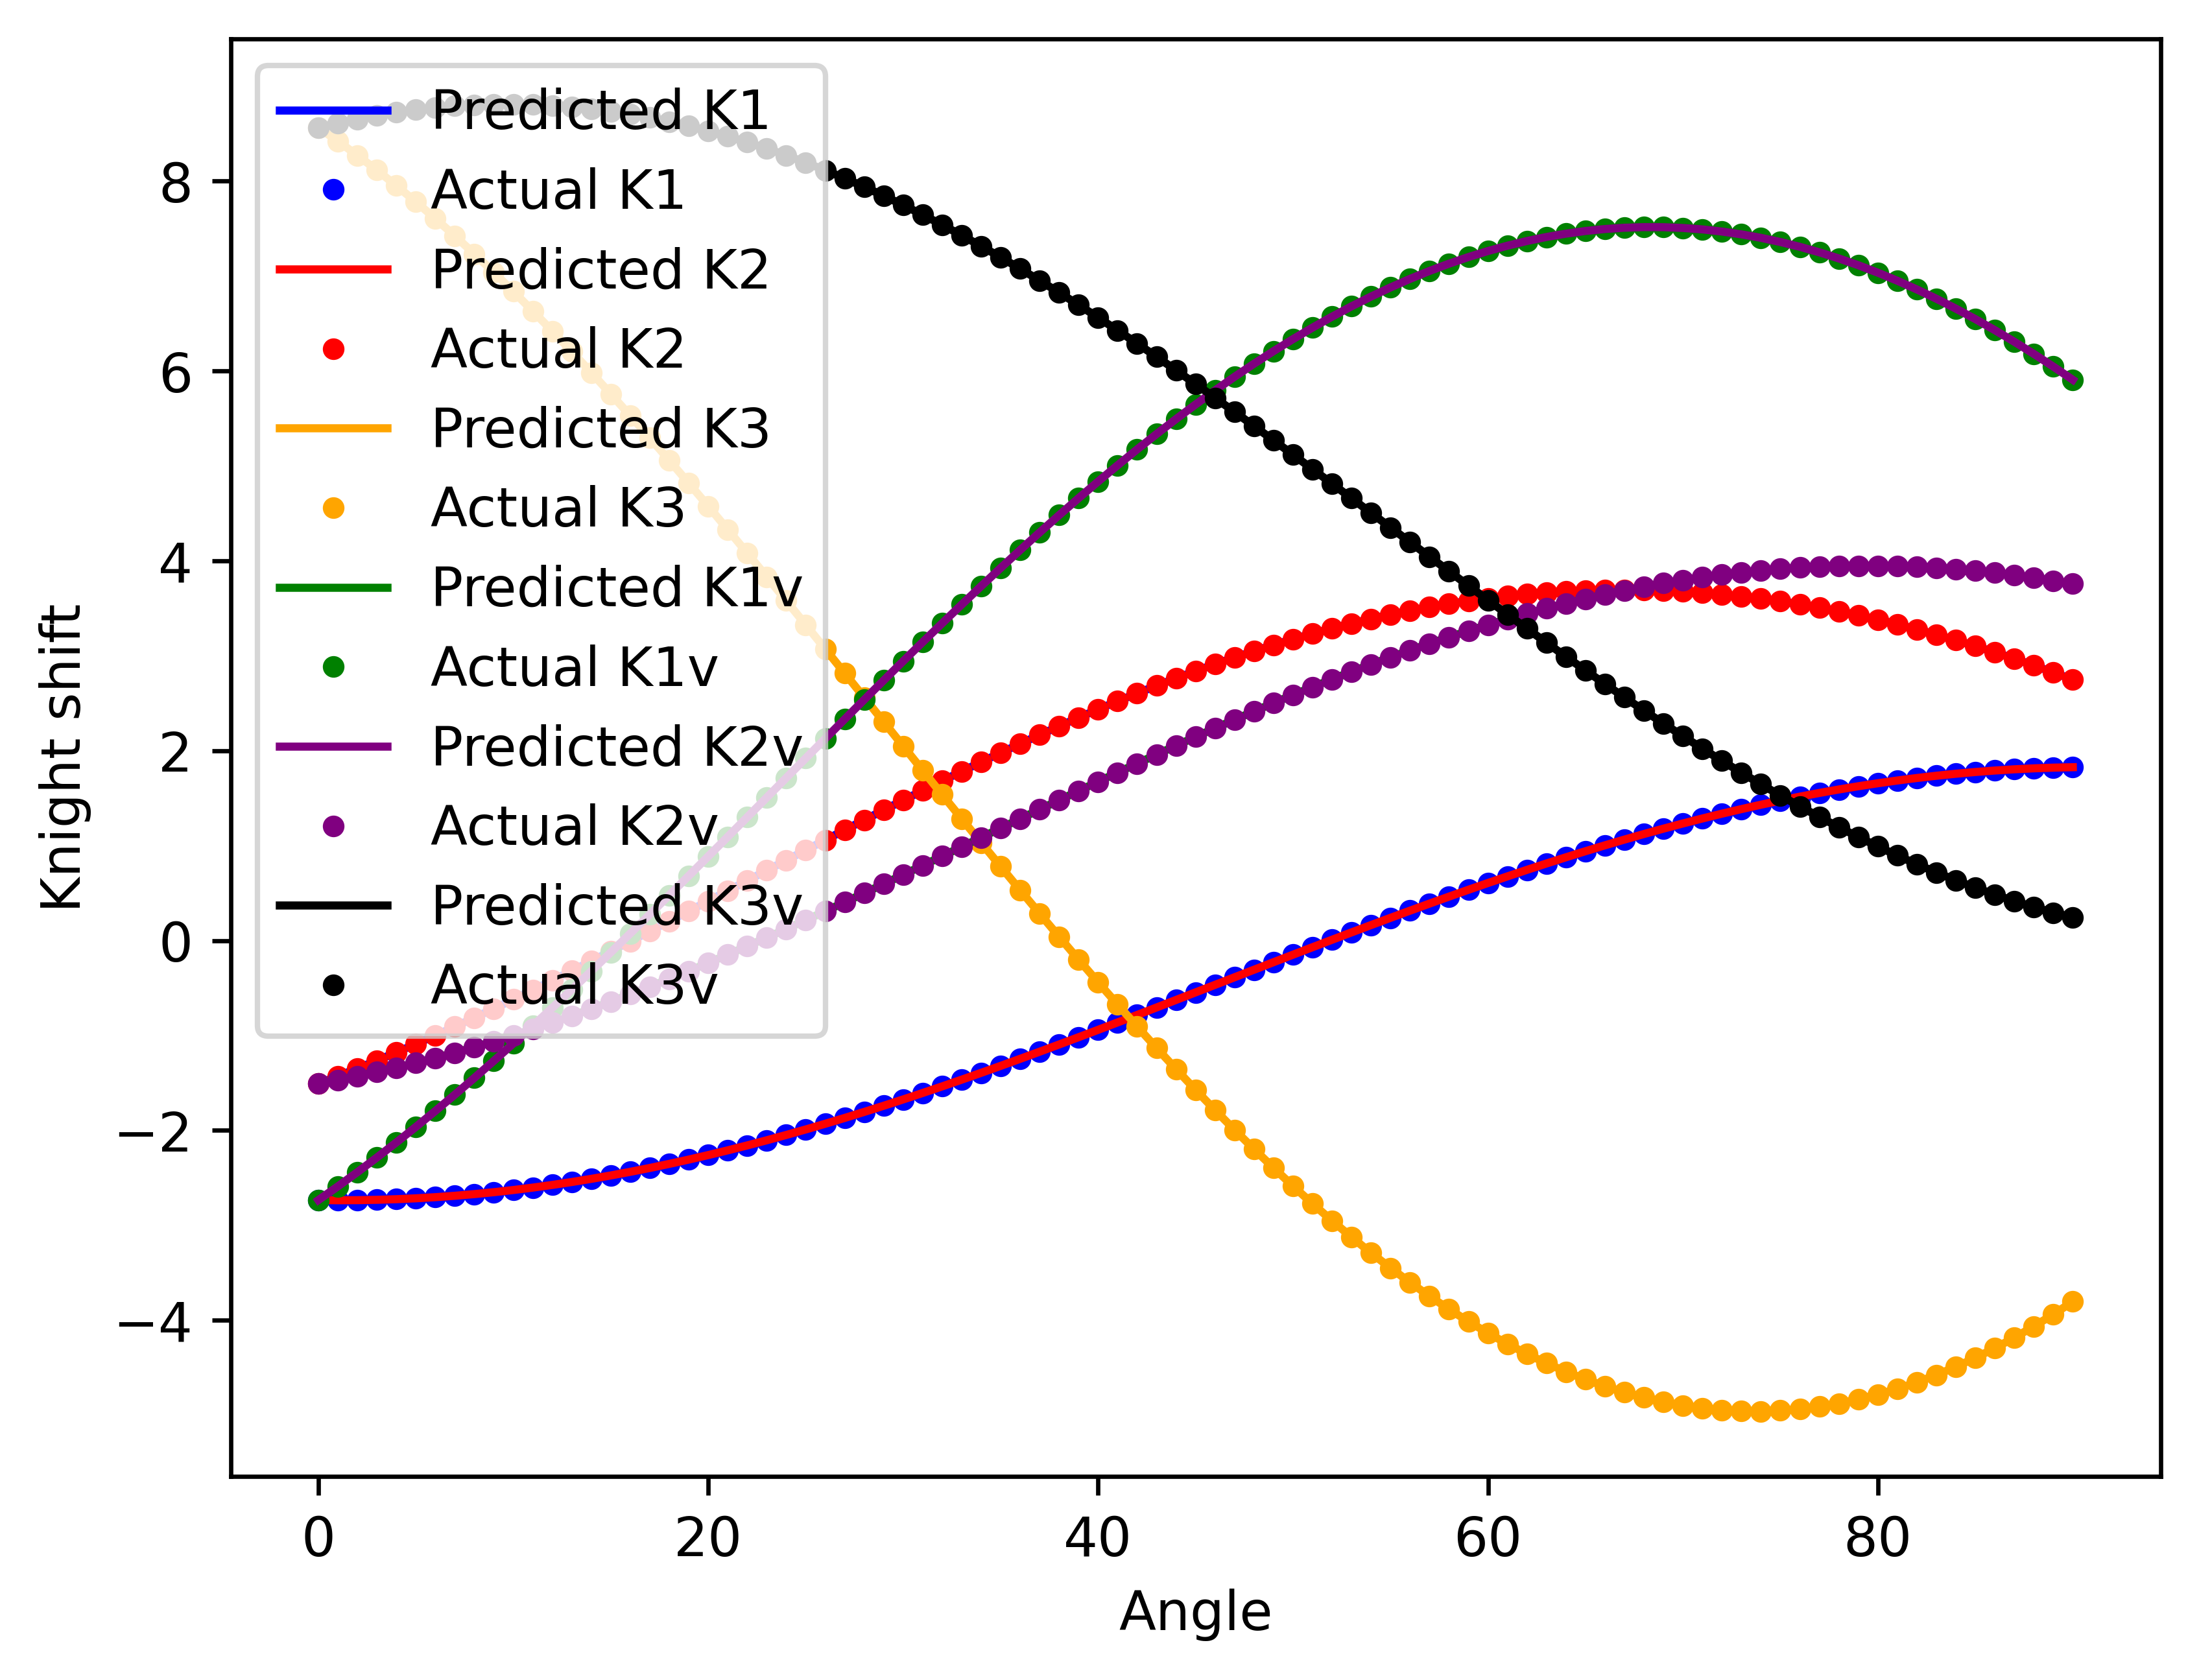

{'k1': -4.999986171722412, 'k2': 4.999992847442627, 'k3': 5.000004291534424, 'k4': 4.999992847442627, 'k5': 0.0, 'k6': 0.0, 't1': 35.64399719238281, 'p1': 21.17512321472168, 't2': 122.46624755859375, 'p2': 48.64674758911133}


In [11]:
# 最適化後のパラメータを取得し、Tensorに変換
k1 = torch.tensor(global_best_params['k1'], dtype=torch.float32)
k2 = torch.tensor(global_best_params['k2'], dtype=torch.float32)
k3 = torch.tensor(global_best_params['k3'], dtype=torch.float32)
k4 = torch.tensor(global_best_params['k4'], dtype=torch.float32)
k5 = torch.tensor(global_best_params['k5'], dtype=torch.float32)
k6 = torch.tensor(global_best_params['k6'], dtype=torch.float32)
t1 = torch.tensor(global_best_params['t1'], dtype=torch.float32)
p1 = torch.tensor(global_best_params['p1'], dtype=torch.float32)
t2 = torch.tensor(global_best_params['t2'], dtype=torch.float32)
p2 = torch.tensor(global_best_params['p2'], dtype=torch.float32)

# パラメータリストを作成
params = [k1, k2, k3, k4, k5, k6, t1, p1, t2, p2]

outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

y_p1 = outputs[0]['shift1'][0]
y_p2 = outputs[1]['shift1'][1]
y_p3 = outputs[2]['shift1'][2]
y_p4 = outputs[3]['shift2'][0]
y_p5 = outputs[4]['shift2'][1]
y_p6 = outputs[5]['shift2'][2]

# 結果の可視化
fig = plt.figure(dpi=600)

plt.plot(x1.detach().numpy(), y_p1.detach().numpy(), label="Predicted K1", color = "blue") 
plt.plot(x1.detach().numpy(), y1.numpy(), '.', label="Actual K1", color = "blue")

plt.plot(x2.detach().numpy(), y_p2.detach().numpy(), label="Predicted K2", color = "red") 
plt.plot(x2.detach().numpy(), y2.numpy(), '.', label="Actual K2", color = "red")

plt.plot(x3.detach().numpy(), y_p3.detach().numpy(), label="Predicted K3", color = "orange") 
plt.plot(x3.detach().numpy(), y3.numpy(), '.', label="Actual K3", color = "orange")

plt.plot(x4.detach().numpy(), y_p4.detach().numpy(), label="Predicted K1v", color = "green") 
plt.plot(x4.detach().numpy(), y4.numpy(), '.', label="Actual K1v", color = "green")

plt.plot(x5.detach().numpy(), y_p5.detach().numpy(), label="Predicted K2v", color = "purple") 
plt.plot(x5.detach().numpy(), y5.numpy(), '.', label="Actual K2v", color = "purple")

plt.plot(x6.detach().numpy(), y_p6.detach().numpy(), label="Predicted K3v", color = "black") 
plt.plot(x6.detach().numpy(), y6.numpy(), '.', label="Actual K3v", color = "black")

plt.xlabel("Angle")
plt.ylabel("Knight shift")
plt.legend()
plt.show()

# 最適化後のパラメータを表示
print(global_best_params)